In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("microcalcification.csv")

In [3]:
df.head()

,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [4]:
df['Microcalcification'] = df['Microcalcification'].replace({"'-1'":0,"'1'":1})

In [5]:
df['Microcalcification'].value_counts()/df.shape[0]

0    0.97675
1    0.02325
Name: Microcalcification, dtype: float64

The dataset is from the medical diagnosis field. The target is presence or absense of microcalcification  in breast mammograms. It is severely skewed, with the positive class (presence of microcalcifications) representing only 2.3% of the total instances. Since it is important we don't miss any positive classes, recall would be the metric to judge our models. 

In [6]:
cols = df.columns.tolist()
cols.remove('Microcalcification')

# Visualizing the Data

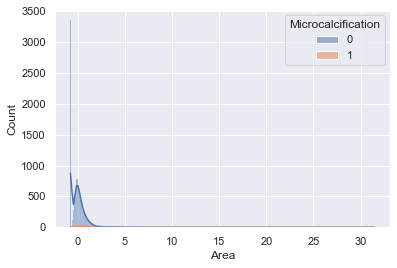

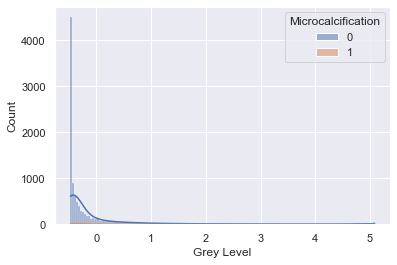

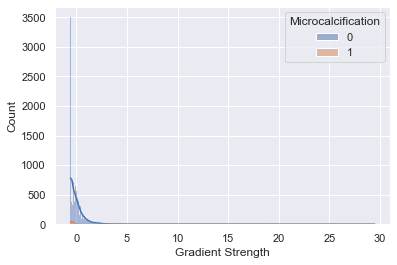

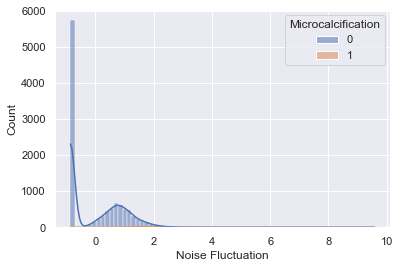

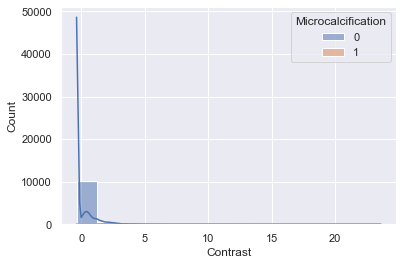

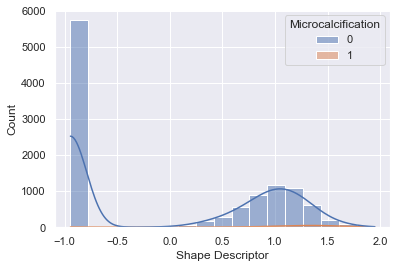

In [7]:
for i in cols:
    sns.histplot(data=df,x=i,hue='Microcalcification',kde=True)
    plt.xlabel(i)
    plt.show()
#we can barely see the minority class

The positive class can barely be seen in the histograms. Lets plot the feature distributions for just the positive class.

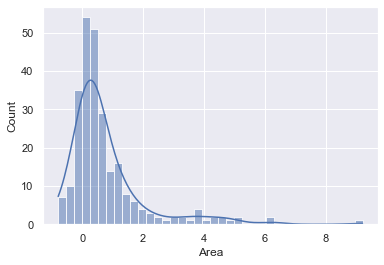

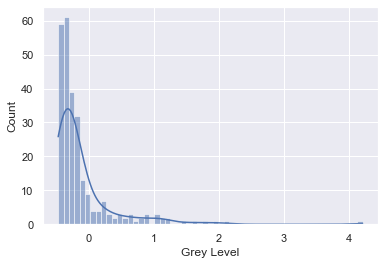

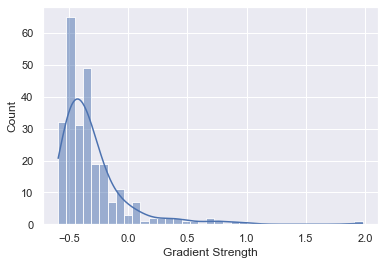

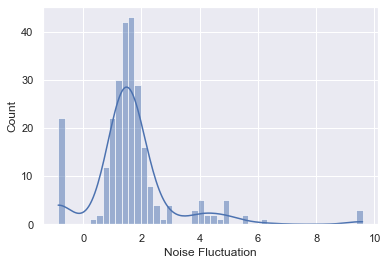

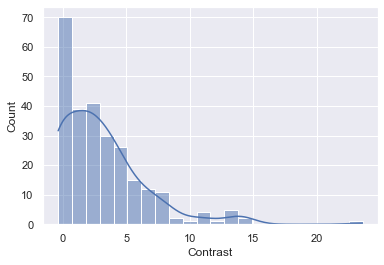

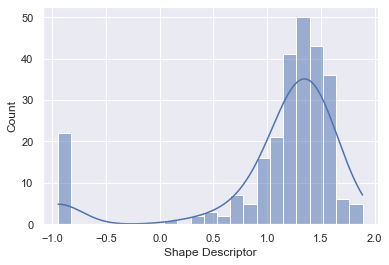

In [8]:
for i in cols:
    sns.histplot(data=df.loc[df['Microcalcification'] == 1],x=i,kde=True)
    plt.xlabel(i)
    plt.show()

In [9]:
#Lets do a PowerTransform and see how the distributions are. They are very skewed now
from sklearn.preprocessing import PowerTransformer

In [10]:
power = PowerTransformer()
power.fit(df.drop('Microcalcification',axis=1))
X = power.transform(df.drop('Microcalcification',axis=1))

In [11]:
df = pd.concat([pd.DataFrame(X,columns=cols),df['Microcalcification']],axis=1)

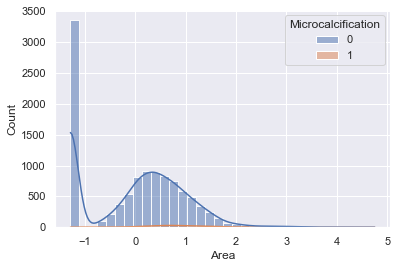

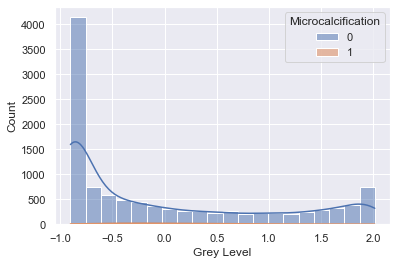

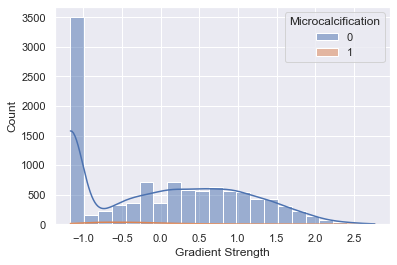

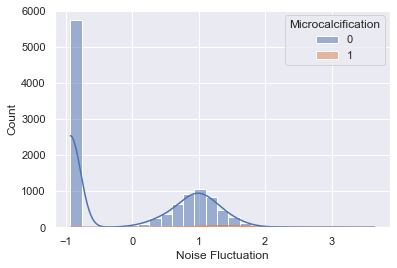

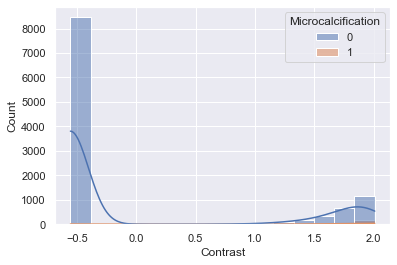

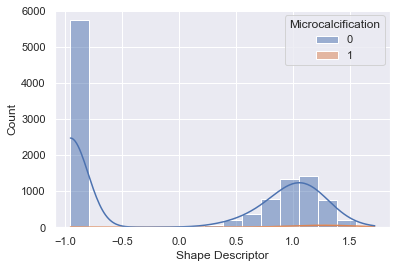

In [12]:
for i in cols:
    sns.histplot(data=df,x=i,hue='Microcalcification',kde=True)
    plt.xlabel(i)
    plt.show()

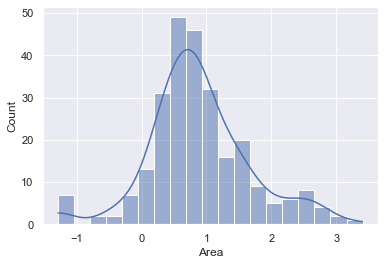

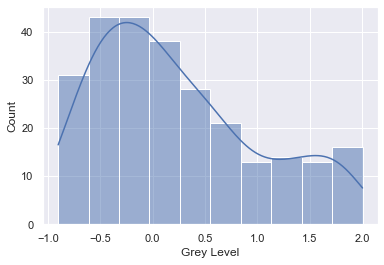

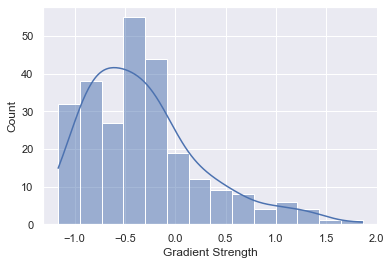

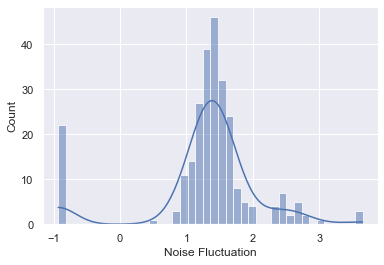

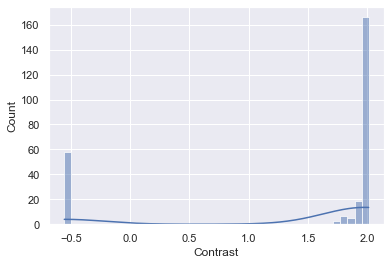

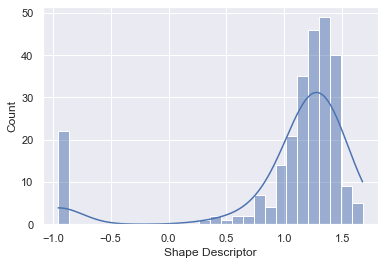

In [13]:
for i in cols:
    sns.histplot(data=df.loc[df['Microcalcification'] == 1],x=i,kde=True)
    plt.xlabel(i)
    plt.show()

The skew is markedly less now.

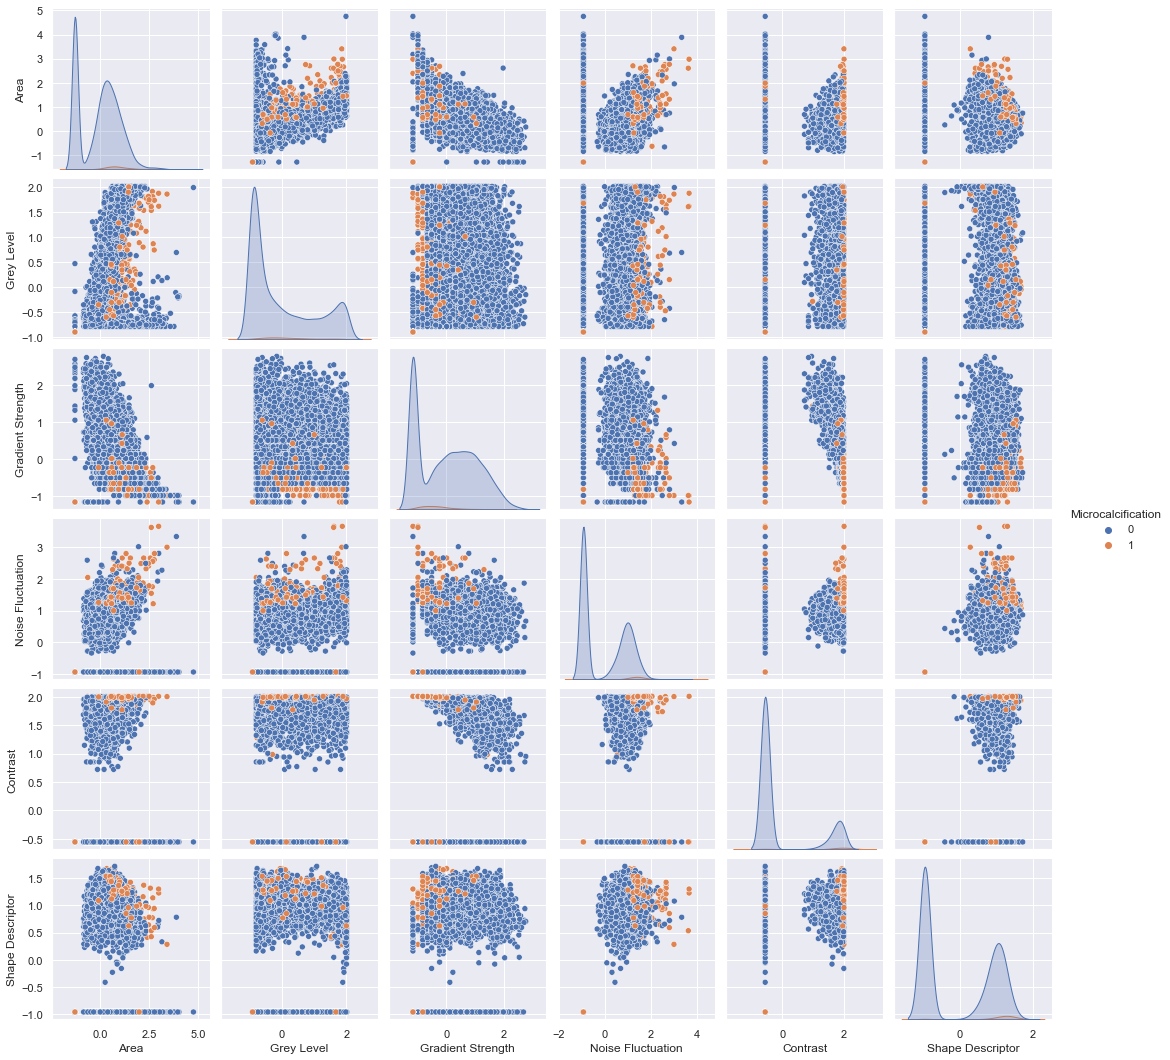

In [14]:
sns.pairplot(data=df,hue='Microcalcification')
plt.show()

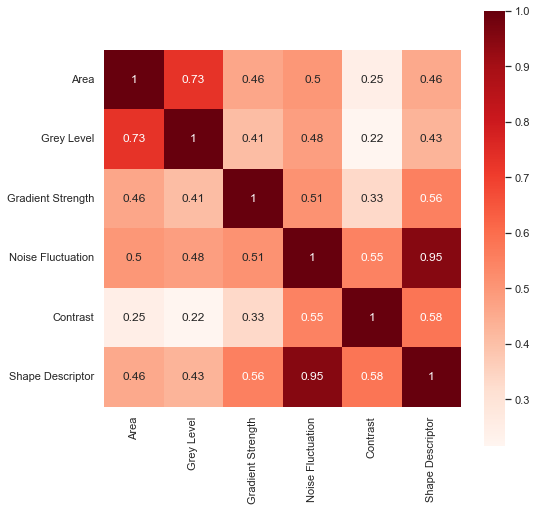

In [15]:
corr = df.drop('Microcalcification',axis=1).corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap='Reds',annot=True,cbar=True,square=True,ax=ax)
plt.show()

# Fitting a Neural Network Model

We will a neural network model with early stopping regularization.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

trainX, X_test, trainY, y_test = train_test_split(df.drop('Microcalcification',axis=1),df['Microcalcification'],test_size=0.2,random_state=3)

scaler = MinMaxScaler()
scaler.fit(trainX)

def data_transformer(X,y):
    return scaler.transform(X),y.to_numpy()

#making validation set
X_train, X_valid, y_train, y_valid = train_test_split(trainX,trainY,test_size=0.2,random_state=2)

X_train, y_train = data_transformer(X_train, y_train)
X_valid, y_valid = data_transformer(X_valid, y_valid)
X_test, y_test = data_transformer(X_test, y_test)

In [17]:
print("Fraction of 1s in training set: %s"%(y_train.sum()/y_train.shape[0]))
print("Fraction of 1s in validation set: %s"%(y_valid.sum()/y_valid.shape[0]))
print("Fraction of 1s in test set: %s"%(y_test.sum()/y_test.shape[0])) 

Fraction of 1s in training set: 0.025013974287311346
Fraction of 1s in validation set: 0.017877094972067038
Fraction of 1s in test set: 0.021904336164506034


Checking the fraction of class 1 in the various sets. They are close enough to the original dataset.

In [18]:
from sklearn.metrics import accuracy_score, recall_score
import torch
import torch.nn as nn

In [19]:
def to_tensor(X,y):
    Xt = torch.from_numpy(X).to(torch.float)
    yt = torch.from_numpy(y).reshape(-1,1).to(torch.float)
    return Xt, yt

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)
Xt_test, yt_test = to_tensor(X_test, y_test)

In [20]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(6,50), nn.ReLU(),
                                    nn.Linear(50,10), nn.ReLU(),
                                    nn.Linear(10,1), nn.Sigmoid())
        
    def forward(self,x):
        return self.layers(x)
    
def train(model, n_epoch, patience, lr, plotloss, plotmetrics, X_train, X_valid, y_train, y_valid):
    
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    last_loss = 100.
    trigger = 0
    
    if(plotloss):
        epoch_loss_train = list()
        epoch_loss_valid = list()
    
    if (plotmetrics):
        epoch_score_train = list()
        epoch_score_valid = list()
        epoch_recall_train = list()
        epoch_recall_valid = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
        
        if (plotmetrics):
            epoch_score_train.append(model_accuracy(X_train, y_train))
            epoch_score_valid.append(model_accuracy(X_valid, y_valid))
            epoch_recall_train.append(model_recall(X_train, y_train))
            epoch_recall_valid.append(model_recall(X_valid, y_valid))
        
        #early stopping
        y_pred_valid = model(X_valid)
        loss_valid = criterion(y_pred_valid,y_valid)
        new_loss = loss_valid.item()
        if (plotloss):
            epoch_loss_train.append(loss.item())
            epoch_loss_valid.append(new_loss)
        
        if(new_loss > last_loss):
            trigger += 1
            if(trigger > patience):
                print("Early Stopping at Epoch {}".format(epoch))
                break
        else:
            trigger = 0
        last_loss = new_loss
        
    plt.plot(epoch_loss_train)
    plt.plot(epoch_loss_valid)
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    if(plotmetrics):
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        ax1.plot(epoch_score_train)
        ax1.plot(epoch_score_valid)
        ax1.set_ylim(0,1)
        ax1.set_xlabel('Epoch')
        ax1.set_title('Accuracy Score')
        
        ax2.plot(epoch_recall_train)
        ax2.plot(epoch_recall_valid)
        ax2.set_ylim(0,1)
        ax2.set_xlabel('Epoch')
        ax2.set_title('Recall Score')
        
        fig.legend(['Training','Validation'])
        plt.show()
    return model

def model_prediction(X):
    y = model(X).detach().numpy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    return y

def model_accuracy(X,y):
    y_pred = model_prediction(X)
    return accuracy_score(y,y_pred)

def model_recall(X,y):
    y_pred = model_prediction(X)
    return recall_score(y,y_pred)    

def model_scores(X,y):
    print("Accuracy: %s"%model_accuracy(X,y))
    print("Recall:   %s"%model_recall(X,y))

Epoch 100, Loss 0.2547414302825928
Epoch 200, Loss 0.13495148718357086
Epoch 300, Loss 0.0986921414732933
Epoch 400, Loss 0.08251386135816574
Epoch 500, Loss 0.0707874596118927
Epoch 600, Loss 0.0629325583577156
Epoch 700, Loss 0.05920917168259621
Epoch 800, Loss 0.05670816823840141
Epoch 900, Loss 0.054698873311281204
Epoch 1000, Loss 0.05317193642258644


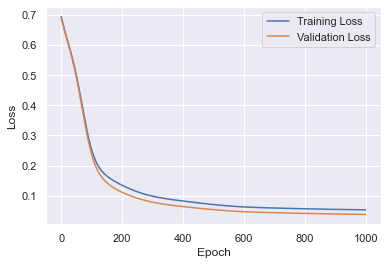

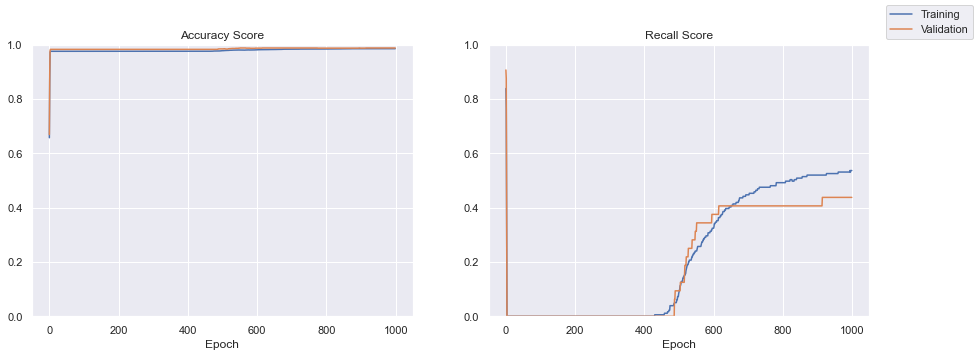

Test Set
Accuracy: 0.9874832364774251
Recall:   0.5102040816326531
Training Set
Accuracy: 0.9846282839575181
Recall:   0.5363128491620112
Validation Set
Accuracy: 0.9871508379888269
Recall:   0.4375


In [21]:
n_epoch = 1000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = NN()
model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

Performance is pretty bad with respect to recall. Lets bring in our secret weapon - oversampling the minority class.

# Oversampling the Minority Class

In [22]:
traindf = pd.concat([trainX,pd.DataFrame(trainY)],axis=1)

n0, n1 = traindf['Microcalcification'].value_counts() #number of instances in each class

class0 = traindf[traindf['Microcalcification']==0]
class1 = traindf[traindf['Microcalcification']==1]

In [23]:
print("Before Resampling")
print("Fraction of Class 1: {}".format(n1/(n0+n1))) 
#lets boost % of class 1 from 14% to ~40% of total
#taking 28*n1 samples gives ~40% of total

class1over = class1.sample(28*n1,replace=True) 
overdf = pd.concat([class0,class1over],axis=0).sample(frac=1)

print("After Resampling")
print("Fraction of Class 1: {}".format(overdf['Microcalcification'].value_counts()[1]/overdf['Microcalcification'].value_counts().sum()))

Before Resampling
Fraction of Class 1: 0.023585960205678515
After Resampling
Fraction of Class 1: 0.4034692344464932


In [24]:
#making new training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(overdf.drop('Microcalcification',axis=1),overdf['Microcalcification'],test_size=0.2,random_state=2)
X_train, y_train = data_transformer(X_train, y_train)
X_valid, y_valid = data_transformer(X_valid, y_valid)

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)

Epoch 200, Loss 0.2574675679206848
Epoch 400, Loss 0.24764417111873627
Epoch 600, Loss 0.24088901281356812
Epoch 800, Loss 0.23641999065876007
Epoch 1000, Loss 0.23123762011528015
Epoch 1200, Loss 0.22511045634746552
Epoch 1400, Loss 0.2185935229063034
Epoch 1600, Loss 0.2123832106590271
Epoch 1800, Loss 0.2069638967514038
Epoch 2000, Loss 0.20071019232273102


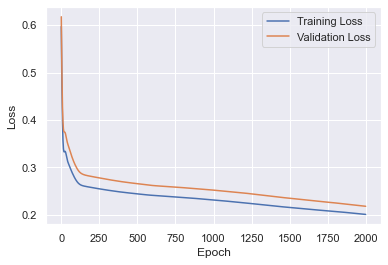

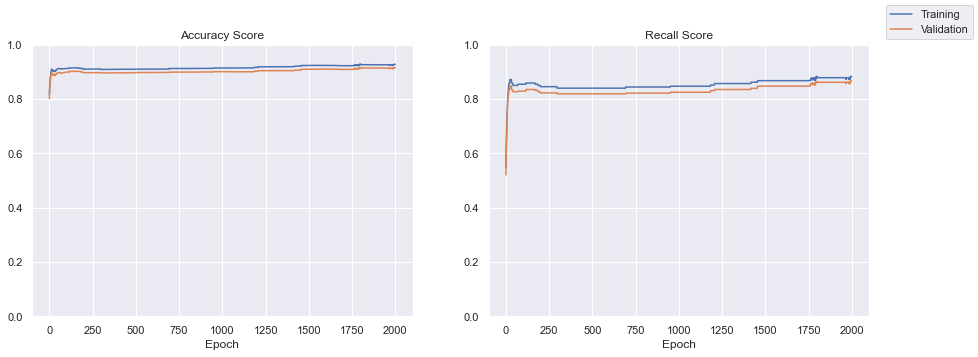

Test Set
Accuracy: 0.9561913276709879
Recall:   0.8571428571428571
Training Set
Accuracy: 0.927266518695578
Recall:   0.8822779430514237
Validation Set
Accuracy: 0.9149880505291909
Recall:   0.8660565723793677


In [25]:
#continue training model from before
n_epoch = 2000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

Epoch 200, Loss 0.19076617062091827
Epoch 400, Loss 0.18114127218723297
Epoch 600, Loss 0.17536573112010956
Early Stopping at Epoch 655


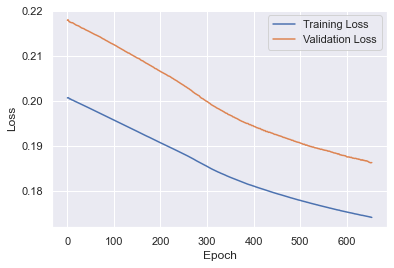

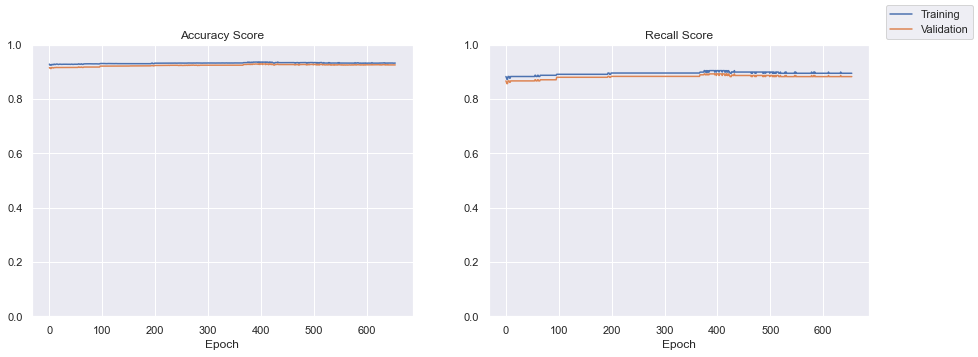

Test Set
Accuracy: 0.953956191327671
Recall:   0.8979591836734694
Training Set
Accuracy: 0.9317056513573502
Recall:   0.894177645558861
Validation Set
Accuracy: 0.9248890406282008
Recall:   0.8818635607321131


In [26]:
#we haven't hit early stopping break yet. Let's train the model some more
n_epoch = 2000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

### On test set, we see a bump in recall from 51.02% to 89.80% (76% increase)
### It comes at the expense of a slight decrease in accuracy, from 98.75% to 95.40% (3% descrease)

I think we can afford to lose that much accuracy, when we get such stellar gain in recall from a simple approach.